In [7]:
import os
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


 #### Parameters

In [8]:
# Define constants
W, H = 224, 224
batch_size = 8
n_epoch = 30
drop_rate = 0.5

train_image_directory = 'Dog-Emotion/train'
valid_image_directory = 'Dog-Emotion/valid'


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


 #### Classes

In [10]:
class_names = [name for name in os.listdir(train_image_directory) if os.path.isdir(os.path.join(train_image_directory, name))]
class_names_label = {name: i for i, name in enumerate(class_names)}
print("Class Names:", class_names)
print("Class Names Labels:", class_names_label)


Class Names: ['relaxed', 'sad', 'happy', 'angry']
Class Names Labels: {'relaxed': 0, 'sad': 1, 'happy': 2, 'angry': 3}


 ##### Plot a batch of images

In [11]:
def show_images(images, labels):

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    grid_img = make_grid(images, nrow=8)
    grid_img = grid_img.numpy().transpose((1, 2, 0))
    grid_img = std * grid_img + mean
    grid_img = np.clip(grid_img, 0, 1)

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(grid_img)
    plt.show()


 #### Transformation for the training and valid

 added a horizontal flip for the training data

In [12]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_image_directory, transform=transform_train)
valid_dataset = datasets.ImageFolder(valid_image_directory, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


 ##### Plot a batch of images

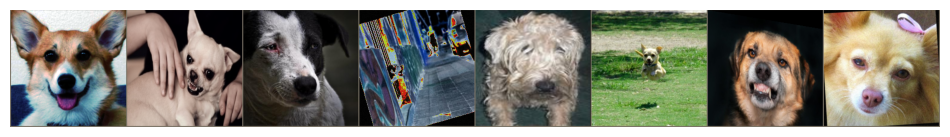

In [13]:
# Visualize some training images
images, labels = next(iter(train_loader))
show_images(images, labels)


 ##### Optimizer and model loading (ConvNeXt Large - Fine-tuning)

 using cross entropy loss with label smoothing, AdamW, and Cosine Annealing scheduler

In [14]:
model = models.convnext_large(weights=ConvNeXt_Large_Weights.DEFAULT)

# unfreeze all model parameters
for param in model.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)


model = model.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch, eta_min=1e-6)



 #### Training and validation loops

In [15]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=5):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            
            # Gradient Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        val_epoch_loss = val_running_loss / len(valid_loader.dataset)
        val_epoch_acc = val_running_corrects / len(valid_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)
        
        # Step the scheduler
        scheduler.step()

        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_convnext_model.pth')
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_acc, val_acc, train_loss, val_loss


 #### Training loss, accuracy and confusion matrix plots

In [16]:
def plot_metrics(train_acc,val_acc,train_loss,val_loss):
    plt.figure(1, figsize=(15, 8))

    plt.subplot(221)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(222)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(model, valid_loader):
    # Load the best model weights
    model.load_state_dict(torch.load('best_convnext_model.pth'))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(valid_dataset.classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [17]:
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=n_epoch)

/tmp/ipykernel_18821/2234057870.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_18821/2234057870.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_18821/2234057870.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


New best model saved with validation accuracy: 0.6275
Epoch 1/30, Train Loss: 1.2850, Train Acc: 0.4608, Val Loss: 1.1529, Val Acc: 0.6275
New best model saved with validation accuracy: 0.7781
Epoch 2/30, Train Loss: 1.0225, Train Acc: 0.7167, Val Loss: 0.8414, Val Acc: 0.7781
New best model saved with validation accuracy: 0.8294
Epoch 3/30, Train Loss: 0.7699, Train Acc: 0.8050, Val Loss: 0.6741, Val Acc: 0.8294
New best model saved with validation accuracy: 0.8506
Epoch 4/30, Train Loss: 0.6596, Train Acc: 0.8483, Val Loss: 0.6297, Val Acc: 0.8506
New best model saved with validation accuracy: 0.8594
Epoch 5/30, Train Loss: 0.5911, Train Acc: 0.8788, Val Loss: 0.6131, Val Acc: 0.8594
New best model saved with validation accuracy: 0.8662
Epoch 6/30, Train Loss: 0.5439, Train Acc: 0.9179, Val Loss: 0.6053, Val Acc: 0.8662
New best model saved with validation accuracy: 0.8681
Epoch 7/30, Train Loss: 0.5152, Train Acc: 0.9283, Val Loss: 0.6013, Val Acc: 0.8681
New best model saved with v

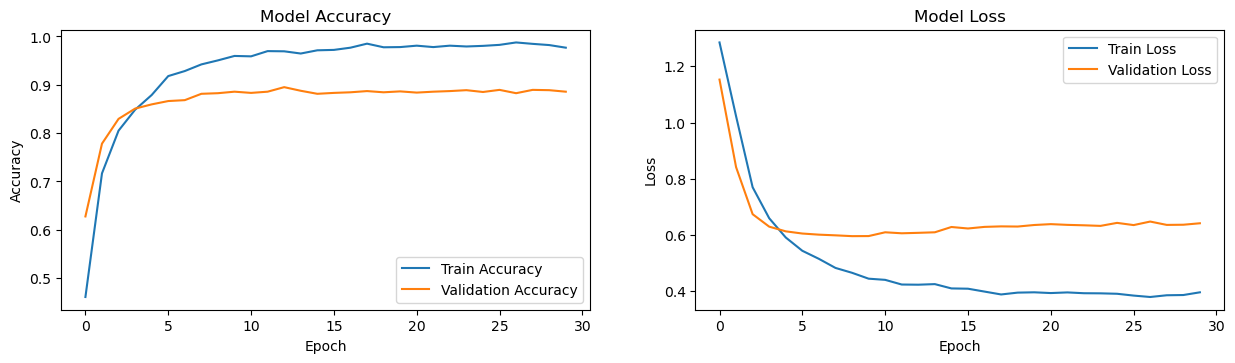

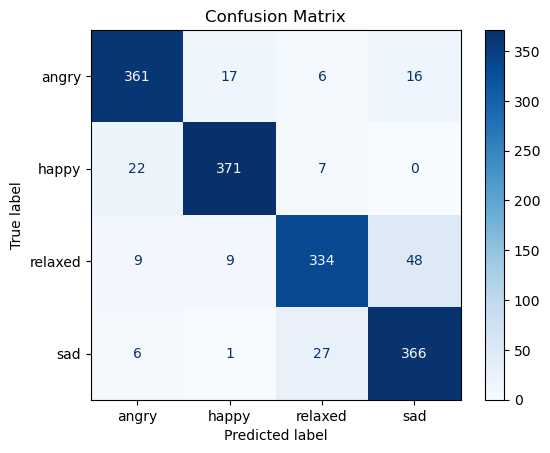

In [18]:
plot_metrics(train_acc,val_acc,train_loss,val_loss)
plot_confusion_matrix(model,valid_loader)